In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
import keras_tuner as kt
from tensorflow.python.client import device_lib
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [ ]:
# can check if you are using your GPU. 
# macOS users -> this will not work, you need to go through a great deal of pain to get it working

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("GPU yes")
else:
    print("No GPU")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
nl_df = pd.read_csv('/Users/lpaggen/Documents/DACS COURSES/Project2-2/Project2-2/Project_2-2/netherlands_data/train_set/processed_data.csv')

In [ ]:
nl_df.head()

In [ ]:
ams_df = nl_df[(nl_df['latitude'] == 52.25) & (nl_df['longitude'] == 5.)]
ams_df = ams_df.sort_values(by = ['time'])
ams_df = ams_df.set_index('time')
ams_df = ams_df.drop(['latitude', 'longitude', 'surface', 'step', 'number', 'valid_time'], axis = 1)
ams_df['temp'] = ams_df['t2m']
ams_df = ams_df.drop(['t2m'], axis = 1)

In [ ]:
# plot shows cycles, i take into account with dummies, can also decompose etc (i have not done that in a WHILE)

plt.style.use('ggplot')
plt.figure(figsize = (26, 4))
ams_df['temp'].plot(label = 'date', title = "temperature (K) over time")
plt.xlabel('date')
plt.ylabel('temperature (K)')

In [ ]:
ams_df.drop(columns = ['month_1', 'hour_0'], axis = 1, inplace = True)

In [ ]:
# this does the train test split, prints the dimensions too

train_split = round(len(ams_df) * 0.8)
train_set = ams_df.iloc[:train_split, :]
valid_set = ams_df.iloc[train_split:, :]
print(train_set.shape)
print(valid_set.shape)

In [ ]:
X_train, Y_train = train_set.iloc[:, :-1], train_set['temp']
X_valid, Y_valid = valid_set.iloc[:, :-1], valid_set['temp']

In [ ]:
scaler = StandardScaler()
X_train_scaled, X_valid_scaled = scaler.fit_transform(X_train), scaler.fit_transform(X_valid)

In [ ]:
Y_valid = Y_valid.values
Y_train = Y_train.values

In [ ]:
# so, you need a timestep that divides the length of the dataset into an integer.
# it's a fucking pain, but 4 works with all sets if we truncate just a bit here

X_train_scaled, X_valid_scaled, Y_train, Y_valid = X_train_scaled[:-2], X_valid_scaled[:-2], Y_train[:-2], Y_valid[:-2]

In [ ]:
# Reshape the input data to tensors
X_train_tensor = tf.convert_to_tensor(X_train_scaled.reshape(-1, 4, X_train_scaled.shape[1]))
X_valid_tensor = tf.convert_to_tensor(X_valid_scaled.reshape(-1, 4, X_valid_scaled.shape[1]))

# Convert output data to tensors
Y_train_tensor = tf.convert_to_tensor(Y_train.reshape(-1, 4), dtype=tf.float32)
Y_valid_tensor = tf.convert_to_tensor(Y_valid.reshape(-1, 4), dtype=tf.float32)

# DEBUG
print("X_train_tensor shape:", X_train_tensor.shape)
print("X_valid_tensor shape:", X_valid_tensor.shape)
print("Y_train_tensor shape:", Y_train_tensor.shape)
print("Y_valid_tensor shape:", Y_valid_tensor.shape)

**LSTM NOTES**

-> using Adam doesn't give great results
-> using rmsprop gives better results

In [40]:
# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units = hp.Int('units', min_value = 1, max_value = 100, step = 32),
                   input_shape = (X_train_tensor.shape[1], X_train_tensor.shape[2])))
    model.add(Dense(units = 1))

    # Choose optimizer
    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop'])

    if optimizer_choice == 'adam':
        optimizer = Adam(hp.Choice('learning_rate_adam', values=[1e-2, 1e-3, 1e-4]))
    elif optimizer_choice == 'sgd':
        optimizer = SGD(hp.Choice('learning_rate_sgd', values=[1e-2, 1e-3, 1e-4]))
    else:
        optimizer = RMSprop(hp.Choice('learning_rate_rmsprop', values=[1e-2, 1e-3, 1e-4]))
        
    loss_function_choice = hp.Choice('loss', values = ['mse', 'mae', 'huber'])
    
    if loss_function_choice == 'mse':
        loss = 'mse'
    elif loss_function_choice == 'mae':
        loss = 'mae'
    else:
        loss = 'huber'

    model.compile(optimizer = optimizer,
                  loss = loss)
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective = 'val_loss',
    max_trials = 50,
    executions_per_trial = 3,
    directory = 'my_dir',
    project_name = 'lstm_tuner'
)

# Perform the search
tuner.search(
    x = X_train_tensor,
    y = Y_train_tensor,
    epochs = 100,
    batch_size = 128,
    validation_data = (X_valid_tensor, Y_valid_tensor)
)

INFO:tensorflow:Reloading Tuner from my_dir/lstm_tuner/tuner0.json

Search: Running Trial #36

Value             |Best Value So Far |Hyperparameter
64                |32                |units
0.0001            |0.01              |learning_rate
sgd               |sgd               |optimizer
0.0001            |0.01              |learning_rate_adam
0.01              |0.01              |learning_rate_sgd
0.001             |0.0001            |learning_rate_rmsprop



Epoch 1/100


2024-04-24 20:11:40.362844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-24 20:11:40.532780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-24 20:11:41.918808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 6784.1553

2024-04-24 20:11:44.213095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-24 20:11:44.292271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 5s 76ms/step - loss: 6784.1553 - val_loss: 24.0034
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 17.1428 - val_loss: 13.9950
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 11.9504 - val_loss: 9.9845
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 10.4658 - val_loss: 10.1138
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 9.9323 - val_loss: 9.6120
Epoch 6/100
32/32 [==============================] - 0s 9ms/step - loss: 9.6824 - val_loss: 10.8536
Epoch 7/100
32/32 [==============================] - 0s 9ms/step - loss: 9.2972 - val_loss: 8.8344
Epoch 8/100
32/32 [==============================] - 0s 9ms/step - loss: 8.8195 - val_loss: 8.6835
Epoch 9/100
32/32 [==============================] - 0s 9ms/step - loss: 8.8193 - val_loss: 8.6788
Epoch 10/100
32/32 [==============================] - 0s 10ms/step - loss: 8.1301 - val_loss: 8.5566
Epoch 11

KeyboardInterrupt: 

In [41]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 38)[0]

print(f"Optimal hyperparameters:\n{best_hps.values}")

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

# Train the model with the optimal hyperparameters
model.fit(X_train_tensor, Y_train_tensor, epochs=200, batch_size=128, validation_data = (X_valid_tensor, Y_valid_tensor), callbacks = early_stopping)

predictions = model.predict(X_valid_tensor)

Optimal hyperparameters:
{'units': 32, 'learning_rate': 0.01, 'optimizer': 'sgd', 'learning_rate_adam': 0.01, 'learning_rate_sgd': 0.01, 'learning_rate_rmsprop': 0.0001}


Epoch 1/200


2024-04-24 20:12:06.647177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-24 20:12:06.822186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-24 20:12:08.076500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 7414.5034

2024-04-24 20:12:10.300234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-24 20:12:10.372713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 5s 71ms/step - loss: 7414.5034 - val_loss: 43.3151
Epoch 2/200
32/32 [==============================] - 0s 9ms/step - loss: 38.1673 - val_loss: 18.9287
Epoch 3/200
32/32 [==============================] - 0s 9ms/step - loss: 15.5142 - val_loss: 14.7743
Epoch 4/200
32/32 [==============================] - 0s 9ms/step - loss: 13.2786 - val_loss: 14.2531
Epoch 5/200
32/32 [==============================] - 0s 9ms/step - loss: 10.3552 - val_loss: 11.9038
Epoch 6/200
32/32 [==============================] - 0s 10ms/step - loss: 8.8062 - val_loss: 10.4978
Epoch 7/200
32/32 [==============================] - 0s 9ms/step - loss: 8.8224 - val_loss: 9.2089
Epoch 8/200
32/32 [==============================] - 0s 10ms/step - loss: 8.3072 - val_loss: 9.7406
Epoch 9/200
32/32 [==============================] - 0s 9ms/step - loss: 8.1958 - val_loss: 9.9507
Epoch 10/200
32/32 [==============================] - 0s 9ms/step - loss: 8.1950 - val_loss: 10.4010
Epoc

2024-04-24 20:12:17.655443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-24 20:12:17.724313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step


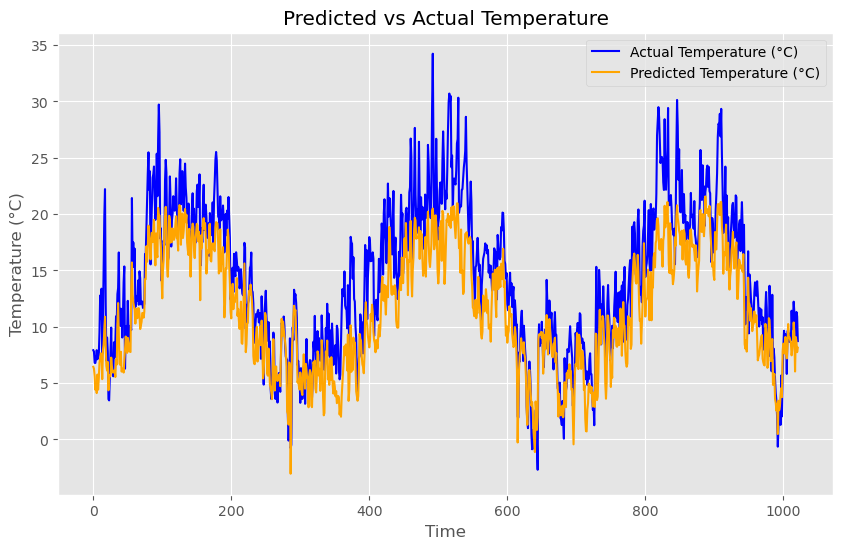

In [42]:
# K -> celcius
Y_valid_celsius = Y_valid_tensor[:, 0] - 273.15
predictions_celsius = predictions - 273.15

# make the plot
plt.figure(figsize=(10, 6))
plt.plot(Y_valid_celsius, label='Actual Temperature (°C)', color='blue')
plt.plot(predictions_celsius, label='Predicted Temperature (°C)', color='orange')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Predicted vs Actual Temperature')
plt.legend()
plt.grid(True)
plt.show()

**VALIDATION/TEST 2024 DATA -> SOLVE ISSUES**

In [43]:
# this formats the test data to have the same format as the rest

test_set = pd.read_csv('/Users/lpaggen/Documents/DACS COURSES/Project2-2/Project2-2/Project_2-2/netherlands_data/test_set/processed_data.csv')
test_set = test_set[(test_set['latitude'] == 52.25) & (test_set['longitude'] == 5.)] # amsterdam data
test_set = test_set.sort_values(by = ['time']) # sorted in ascending order
test_set.set_index(['time'], inplace = True) # replace index
test_set = test_set.drop(['latitude', 'longitude', 'surface', 'step', 'number', 'valid_time'], axis = 1) # get rid of useless columns
test_set[['month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']] = False # add false dummies (match 21 features)
test_set.drop(columns = ['hour_0', 'hour_6', 'hour_12', 'hour_18'], axis = 1, inplace = True)
test_set.index = pd.to_datetime(test_set.index)
test_set_copy = test_set
hour_dummies = pd.get_dummies(test_set_copy.index.hour, prefix='hour')
hour_dummies['time'] = test_set.index
hour_dummies.set_index('time', inplace = True)
test_set_copy_2 = pd.concat([test_set_copy, hour_dummies], axis = 1)
test_set_copy_2['temp'] = test_set['t2m']
test_set_copy_2.drop(columns = ['t2m'], axis = 1, inplace = True)
test_set = test_set_copy_2
test_set.drop(columns = ['month_1', 'hour_0'], axis = 1, inplace = True) # drops the redundant dummies (avoid multicollinearity)

In [44]:
Y_test = test_set['temp']

In [45]:
X_test = test_set.iloc[:, :-1] # temp is last column, this gets all but temp

In [46]:
X_test.shape

(432, 19)

In [47]:
# this casts the bool columns to int for the LSTM to work

X_test[['month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_6', 'hour_12', 'hour_18']] = X_test[['month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_6', 'hour_12', 'hour_18']].astype(int)

In [48]:
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

In [49]:
Y_test = Y_test.values

In [50]:
X_test_tensor = tf.convert_to_tensor(X_test_scaled.reshape(-1, 4, X_test_scaled.shape[1]))

# Convert output data to tensors
Y_test_tensor = tf.convert_to_tensor(Y_test.reshape(-1, 4), dtype=tf.float32)

# DEBUG
print("X_test_tensor shape:", X_test_tensor.shape)
print("Y_test_tensor shape:", Y_test_tensor.shape)

X_test_tensor shape: (108, 4, 19)
Y_test_tensor shape: (108, 4)


In [66]:
test_predict = model.predict(X_test_tensor)

4/4 [==============================] - 0s 4ms/step


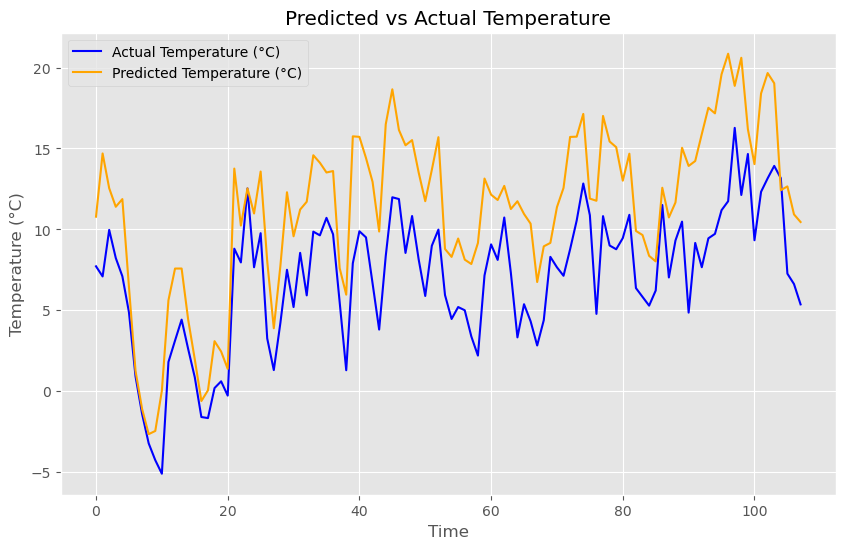

In [67]:
# as you can see we got quite a couple of things to adjust before this thing works well..
# it sucks, but it's a good start

# K -> celcius
Y_valid_celsius = Y_test_tensor[:, 0] - 273.15
predictions_celsius = test_predict - 273.15

# make the plot
plt.figure(figsize=(10, 6))
plt.plot(Y_valid_celsius, label='Actual Temperature (°C)', color='blue')
plt.plot(predictions_celsius, label='Predicted Temperature (°C)', color='orange')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Predicted vs Actual Temperature')
plt.legend()
plt.grid(True)
plt.show()